In [ ]:
#hide
#all_slow

# Training UNET-ResNet34 in FastAI
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/dev_nbs/11_fastai.seg_unet_resnet18.ipynb)
> Training notebook for this architecture.

In [20]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from steel_segmentation.all import *

import fastai
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

In [22]:
fastai.__version__

'2.2.3'

In [23]:
torch.__version__

'1.7.1+cu101'

In [24]:
torch.cuda.device_count(), torch.cuda.is_available()

(1, True)

In [25]:
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [26]:
torch.cuda.empty_cache()

In [27]:
!nvidia-smi

Thu Apr  1 21:23:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        On   | 00000000:00:05.0 Off |                  N/A |
| 46%   33C    P8    12W / 120W |   3911MiB /  8126MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
print_competition_data(models_dir)

../models/fastai-UNET-ResNet34-256-stage5.pth
../models/fastai-UNET-XResNeXt34-128x800.pth
../models/fastai-UNET-XResNeXt34-128x800-finetuning.pth
../models/.ipynb_checkpoints
../models/kaggle-UNET-ResNet34.pth
../models/kaggle-FPN-ResNet34.pth
../models/_tmp.pth


Training a Unet model with `resnet18` encoder with progressive resizing.

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
arch = resnet18

In [31]:
dls = get_segmnt_dls(train_pivot.iloc[:1000], bs=8, flatten_mask=False, device=device)

In [32]:
len(dls.train), len(dls.valid)

(100, 25)

In [33]:
x, targ = dls.one_batch()
x.shape, targ.shape

(torch.Size([8, 3, 256, 256]), torch.Size([8, 4, 256, 256]))

In [34]:
x.device, targ.device

(device(type='cuda', index=0), device(type='cpu'))

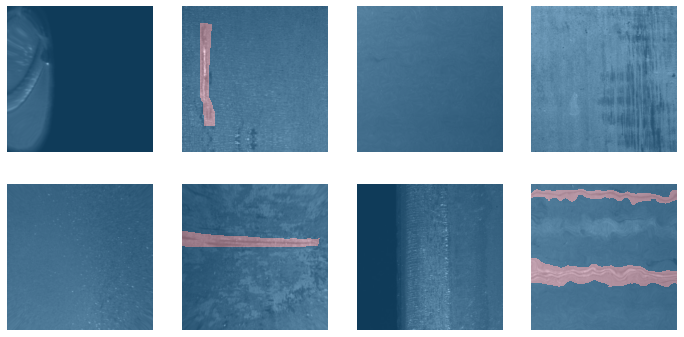

In [35]:
dls.show_batch()

In [36]:
learn = unet_learner(dls, arch, loss_func=SoftBCEDiceLoss(),
                     metrics=[ModDiceMulti],
                     model_dir=models_dir, cbs=[CudaCallback(), ShowGraphCallback()])

In [37]:
#learn.summary()

In [38]:
learn.lr_find()

RuntimeError: result type Float can't be cast to the desired output type Long

In [18]:
learn.fit_one_cycle(5, lr_max=4e-5)

epoch,train_loss,valid_loss,mod_dice_multi,compute_iou_batch,metric,time


TypeError: 'NoneType' object is not iterable

## Results

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet34-Unet-256-stage5")

In [ ]:
segmentation_learner.validate()

(#3) [0.04599599167704582,0.6854738966965712,0.9115328788757324]

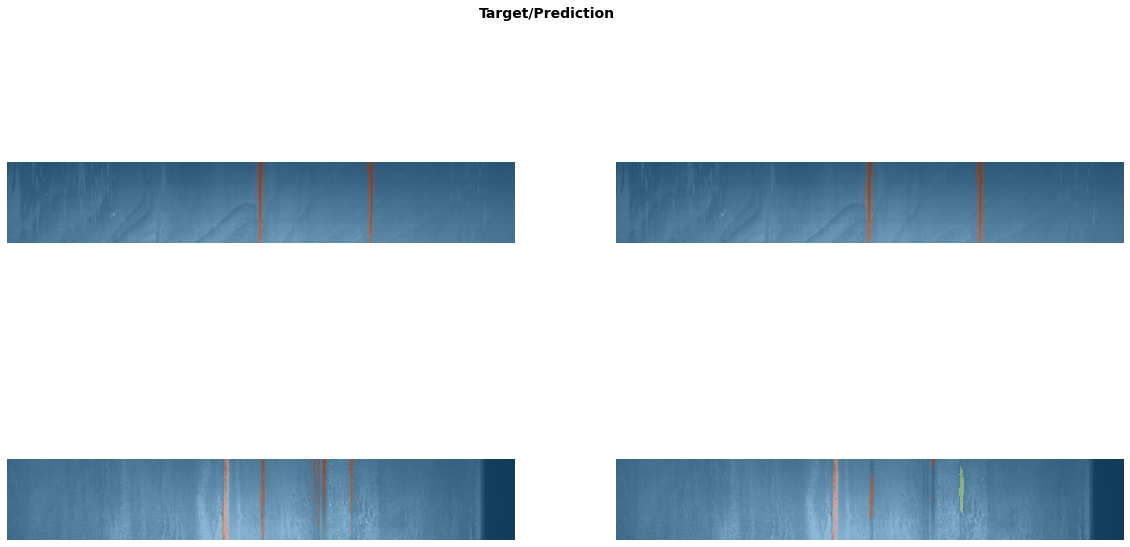

In [ ]:
segmentation_learner.show_results(figsize=(20,10))

## Validation predictions

In [ ]:
bs = 4

In [ ]:
dls = get_segmentation_dls_from_df(train_df=train_all, bs=bs, size=(256, 1600), with_btfms=False)

In [ ]:
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)
segmentation_learner.model_dir = models_dir
segmentation_learner = segmentation_learner.load("ResNet34-Unet-256-stage5")

### On validation set

In [ ]:
pred = FastPredict(dls.valid.items, segmentation_learner)

In [ ]:
# test arguments
size_fold = 100
threshold = 0.5
min_size = 3000

In [ ]:
df_preds = pred(size_fold, threshold, min_size)

From 0 to 100 of 2599


From 100 to 200 of 2599


From 200 to 300 of 2599


From 300 to 400 of 2599


From 400 to 500 of 2599


From 500 to 600 of 2599


From 600 to 700 of 2599


From 700 to 800 of 2599


From 800 to 900 of 2599


From 900 to 1000 of 2599


From 1000 to 1100 of 2599


From 1100 to 1200 of 2599


From 1200 to 1300 of 2599


From 1300 to 1400 of 2599


From 1400 to 1500 of 2599


From 1500 to 1600 of 2599


From 1600 to 1700 of 2599


From 1700 to 1800 of 2599


From 1800 to 1900 of 2599


From 1900 to 2000 of 2599


From 2000 to 2100 of 2599


From 2100 to 2200 of 2599


From 2200 to 2300 of 2599


From 2300 to 2400 of 2599


From 2400 to 2500 of 2599


From 2500 to 2600 of 2599


### On test set for submission

In [ ]:
sub_df = pd.read_csv(path/"sample_submission.csv")
sub_df.shape

(5506, 3)

In [ ]:
pred = FastPredict(sub_df, segmentation_learner, source_path=test_path)

In [ ]:
# test arguments
size_fold = 200
threshold = 0.5
min_size = 2500

In [ ]:
df_preds = pred(size_fold, threshold, min_size)

From 0 to 200 of 5506


From 200 to 400 of 5506


From 400 to 600 of 5506


From 600 to 800 of 5506


From 800 to 1000 of 5506


From 1000 to 1200 of 5506


From 1200 to 1400 of 5506


From 1400 to 1600 of 5506


From 1600 to 1800 of 5506


From 1800 to 2000 of 5506


From 2000 to 2200 of 5506


From 2200 to 2400 of 5506


From 2400 to 2600 of 5506


From 2600 to 2800 of 5506


From 2800 to 3000 of 5506


From 3000 to 3200 of 5506


From 3200 to 3400 of 5506


From 3400 to 3600 of 5506


From 3600 to 3800 of 5506


From 3800 to 4000 of 5506


From 4000 to 4200 of 5506


From 4200 to 4400 of 5506


From 4400 to 4600 of 5506


From 4600 to 4800 of 5506


From 4800 to 5000 of 5506


From 5000 to 5200 of 5506


From 5200 to 5400 of 5506


From 5400 to 5600 of 5506


In [ ]:
pred.make_masks()

In [ ]:
pred.save_submission(file_name="ResNet34-Unet-fastai")